In [ ]:
%load_ext autoreload
%autoreload 2

# Scalable Recognition with a Vocabulary Tree
---

While we introduce the problem, let's download the data we will use throughout this session. 

In [ ]:
!python cbir/download.py

<br>

## **1. Introduction**
---

### 1.1 The image retrieval problem
<hr width=20% align=left>

<img src="images/CBIR.png" height="10" width="400" align="right">


Content-based image retrieval (CBIR) is the process of searching for images in a large database, given a visual query for search. Technically, there are three key components in CBIR:  
  1. Image representation
  2. Database organisation
  3. Image distance measurement



We can further specify the definition of CBIR above.

> CIBR makes use of the ***representation*** of visual content to identify relevant images in a database.


<u>In this lesson we will focus on a **Query-based Image Retrieval** problem, which uses an example image as query.</u>
<br>

> At the end of this session, we expect to be able to have a function as below.  
As we go through the notebook we will learn all the ingredients to implement such function.

In [ ]:
def retrieve(database, query):
    raise NotImplemented

<br>
<br>

**In this session we will reproduce and implement the method from the paper that put the grounds for the Google Search from Images:**  
***[Nister, D. and Stewenius, H., 2006, June. Scalable recognition with a vocabulary tree. In 2006 IEEE Computer Society Conference on Computer Vision and Pattern Recognition (CVPR'06) (Vol. 2, pp. 2161-2168). Ieee.](https://www.imperial.ac.uk/media/imperial-college/faculty-of-engineering/bioengineering/public/directions/Directions-to-Bessemer-Level-4-Meeting-Rooms-1-and-2.pdf)***


### 1.2 CBIR pipeline
<hr width=20% align=left>
We can distinguish two main stages in a CBIR framework: an **offline** stage, and an **online** stage [ref]. These stages constitute the high-level architecture; individual components would make use of a mixture of techniques (including, for example, supervised and unsupervised learning).

<div style="img {align: left}">
<img src="images/pipeline_extended.png">
<em>Image from Zheng et al 2017. "SIFT meets CNN: A decade survey of instance retrieval."</em>
</div>

The objective of the **offline** stage is to use the image stack to build an indexed database. We tend to concentrate most of the computational effort in this stage of creation, to ease, instead, the online stage.
It is concerned with two main operations:
- Create a representation of the images
- Efficiently index the images 



Given a *query* image, the objective of the **online** stage is to score part (or all) of the images in the database, and return the ones with the higest scores.



This is how we would implement a simple CBIR system:  we will divide the CBIR into different functionalities and address each functional block as we go through the notebook. In the last part of the session, we will put everything together.

In [ ]:
class CBIR:
    def __init__(self, dataset):
        self.dataset = dataset
        self.database = None  # we haven't built an indexed database yet
        return
    
    #-- TASK 1
    def find_keypoints(self, image):
        # Implement me using MSER, please
        raise NotImplemented
        
    #-- TASK 2
    def extract_features(self, image):
        # Implement me using SIFT, please
        raise NotImplemented
    
    #-- TASK 3
    def create_vocabulary(self, image):
        # Implement me using extract_features and BOW, please
        raise NotImplemented

    #-- TASK 4
    def encode(self, dataset):
        # Implement me using vocabulary tree, please
        raise NotImplemented
    
    #-- TASK 5
    def score(self, image):
        raise NotImplemented
    
    #-- TASK 6
    def retrieve(self, query):
        # this is the function we have described above
        raise NotImplemented

<br>

## **2. Features Extraction**


### 2.1 Find keypoints
<hr width=20% align=left>

<div style="margin:auto; float:right; margin-left: 50px; width: 45%">
<img src="images/features_extraction_only.jpeg">
<em>The decomposition of an image into several "distinctive" localized regions</em>
</div>

<p style="color: #a00; font-weight: 700">>> TASK 1</p>

> In this section we are going to learn how to implement the function:
```python
def find_keypoints(self, image):
    raise features
```
which extract a set of keypoints later used to describe the image.

Keypoints can be thought of as **landmarks** in a scene. Similar to the intuitive "human" notion of landmarks, keypoints are distinctive locations in space. Unlike what humans treat as a landmark, they can be computed
directly from image data, based on the principle that landmarks should be relatively sparse, distinctive, and stable. Once landmarks have been found, they can be used as reference points around which to build descriptions of surrounding image structure.

#### Manipulating images

To perform fast manipulations on the images, we will use the [open-cv library](https://docs.opencv.org/master/d6/d00/tutorial_py_root.html). We start by importing it, together with the `numpy` library and the `matplotlib` library for image plotting.

We also call some functions that take care of handling our image dataset, manipulating and showing our images, and showing the landmark points that we are going to detect.

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

import cbir

# Loading the dataset
dataset = cbir.Dataset()
descriptor = cbir.descriptors.Orb()

Let's look at a random image from the dataset:

In [ ]:
img = dataset.get_random_image()

# Plotting the image
plt.figure(figsize=(10,10))
dataset.show_image(img)
plt.title("Random image from the dataset")
plt.show()

### Corner detector 

A possible set of interesting points is given by the corners of the objects in the image. We will use the corner detector operator developed by [Harris and Stephens](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html), to extract them from the image.

Let's start by loading an image with well defined corners. We will load it in grayscale.
We can also freely manipulate the image using `numpy`, as in the following example

In [ ]:
# Loading and displaying an image
img = dataset.read_image('110901.jpg')
z = np.sin(img/10.)

# Plotting functions
plt.figure(figsize=(12,4))
plt.subplot(121)
dataset.show_image(img, gray=True)
plt.title('110901.jpg')
plt.subplot(122)
dataset.show_image(z, gray=True)
plt.title("$\sin(I/10)$")
plt.show()

The opencv implementation of the detector is found in `cv2.cornerHarris()` ([here is the documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornerharris#cornerharris)). You can try to tune the parameters of the function to improve your corner detection. You are also invited to experiment with different pitcures

In [ ]:
# Corner Detector parameters
block_size = 11
kernel_size = 31
aperture_parameter = 0.01
treshold = 0.01

# Detection
gray= cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
dst = cv2.cornerHarris(gray, 
                       blockSize=block_size, 
                       ksize=kernel_size, 
                       k=aperture_parameter)
dst = dst > treshold*dst.max()

plt.figure(figsize=(15,10))
descriptor.show_corners_on_image(gray,dst)

> ***Action:*** try changing the images above and the parameters of the corner detector, to see how this affect the results. Take a look at [the documentation](https://docs.opencv.org/2.4/modules/imgproc/doc/feature_detection.html?highlight=cornerharris#cornerharris) of the `cv2.cornerHarris()` function for more details about the meaning of each parameter.

#### Better keypoint detectors

Clearly, corners are not the only interesting locations of an image. This calls for more general and sophisticated keypoints detectors. 

An example of a modern keypoint detector is the [Scale Invariant Feature Transform (SIFT)](https://link.springer.com/content/pdf/10.1023/B:VISI.0000029664.99615.94.pdf) method. SIFT is an image descriptor for image-based matching and recognition developed by David Lowe (1999, 2004). This descriptor, as well as related image descriptors, are used for a large number of purposes in computer vision for point matching between different views of a 3-D scene, and view-based object recognition. The SIFT descriptor is approximately invariant to translations, rotations and scaling transformations in the image domain and robust to moderate perspective transformations and illumination variations [Lowe, 2004].

Another advanced keypoint detector (and descriptor, as we will see later) is given by the [ORB detector (Oriented FAST and Rotated BRIEF](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html), which is a faster but slightly less accurate version of SIFT.

In the following code, you will set up an ORB detector function which you can test on different images. Now one could use this function on the entire dataset, building a list of interesting keypoints for each image. 

> ***Action:*** After looking at the [documentation for the ORB detector](https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html#adc371099dc902a9674bd98936e79739c), especially the `create()` and `detect()` methods, try implement to the function below, which takes an image as input and returns a list of [keypoints](https://docs.opencv.org/3.4/d2/d29/classcv_1_1KeyPoint.html) generated by the ORB detector.

<details>
<summary>Solution</summary>

```python
def find_keypoints(image):
    ''' This function should take an image as input and return a list
    of keypoints as output
    '''
    
    # Creating the detector and setting some properties
    orb = cv2.ORB.create()
    
    # Detecting the keypoints
    keypoints = orb.detect(image)
    
    return keypoints
```  
</details>

In [ ]:
def find_keypoints(image):
    ''' This function should take an image as input and return a list
    of keypoints as output
    '''
    # Creating the detector and setting some properties
    orb = cv2.ORB.create()

    # Detecting the keypoints
    keypoints = orb.detect(image)

    return keypoints

We now have a function to detect the keypoints, together with their scale and orientation.

In [ ]:
img = dataset.read_image('110901.jpg')

keypoints = find_keypoints(img)

plt.figure(figsize=(15,10))
# Only displaying every 10 keypoints
img2 = cv2.drawKeypoints(img, keypoints[::10], None, color=(0,255,0), flags=4)
dataset.show_image(img2)

> ***Action:*** After looking at the [documentation for the ORB detector](https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html#adc371099dc902a9674bd98936e79739c), try to change some parameters to see how the keypoints detection is affected. Note that, as a rule of thumb, a good image description requires around 1500 keypoints at different scales.

You can also try it on different images while you modify its implementation / parameters, to get an idea of the weaknesses and strenghts of the method

In [ ]:
# Try on a random image of the dataset
img = dataset.get_random_image()

keypoints = find_keypoints(img)

plt.figure(figsize=(15,10))
img2 = cv2.drawKeypoints(img, keypoints[::5], None, color=(255,0,0), flags=4)
dataset.show_image(img2)

<br>
<br>

**2.2 Extract local features**  
<hr width=20% align=left>
<div style="margin: auto; float: left; margin-right: 50px; width: 19%">
<img src="images/bow.png">
<em>Bag of visual words <a href="https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb">[source]</a></em>
</div>



To summarize all the interesting features of a given image, we will implement the ["Bag of visual words" model](https://towardsdatascience.com/bag-of-visual-words-in-a-nutshell-9ceea97ce0fb). It borrows the "bag of words" concept from the natural language processing field, and implements a visual surrogate.

<div style="margin-left: 230px">
<br>
    
    
<p style="color: #a00; font-weight: 700">>> TASK 2</p>
    
> In this section we are going to learn how to implement the function:
```python
def extract_descriptors(image, keypoints):
    return embedding
```
</div>

In CBIR an image is transformed to some kind of feature space. The motivation is to achieve an implicit alignment so as to eliminate the impact of background and potential transformations or changes while keeping the intrinsic visual content distinguishable.


Once we have obtained the features of an image, we will implement the "Bag of visual words" model. It borrows the concept of "bag of words" from the natural language processing field, and implements its visual "equivalent"

> ***Action:*** After looking at the [documentation for the ORB detector](https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html#adc371099dc902a9674bd98936e79739c), try implement to the function below, which takes an image and a list of keypoints as input and returns the computed ORB descriptor as output

<details>
<summary>Solution</summary>

```python
def extract_descriptors(image, keypoints):
    ''' This function should take an image as input and return a list
    of keypoints as output
    '''
    orb = cv2.ORB.create(1500, nlevels=32)
    keypoints, features = orb.compute(image, keypoints)
    return features
```  
</details>

In [ ]:
def extract_descriptors(image, keypoints):
    ''' This function should take an image and keypoints as input and return a list
    of  ORB features as output
    '''
    orb = cv2.ORB.create(1500, nlevels=32)
    keypoints, features = orb.compute(image, keypoints)
    return features

You can try the function by looking at the first **5** descriptors extracted by the algorithm

In [ ]:
img = dataset.read_image('131500.jpg')

keypoints = find_keypoints(img)
features = extract_descriptors(img, keypoints)

print("Descriptor for the 1st keypoint:\n {}".format(features[0]))

Now that we are able to extract some descriptors from the keypoints in the image, let's visualize some of them

In [ ]:
img = dataset.read_image('131200.jpg')
keypoints = find_keypoints(img)
patches = descriptor.extract_patches(img, keypoints)
features = extract_descriptors(img, keypoints)

descriptor.show_random_descriptors(img, keypoints, patches, features)

Of course we can try this on random images too

In [ ]:
img = dataset.get_random_image()

keypoints = find_keypoints(img)
patches = descriptor.extract_patches(img, keypoints)
features = extract_descriptors(img, keypoints)

descriptor.show_random_descriptors(img, keypoints, patches, features)

You have now completed the first half of the tutorial!

Here are a few resources you can consult for more technical informations of keypoints and their description:

1. http://vision.stanford.edu/teaching/cs231a_autumn1112/lecture/lecture11_detectors_descriptors_cs231a.pdf
2. http://vision.stanford.edu/teaching/cs231a_autumn1112/lecture/lecture12_SIFT_single_obj_recog_cs231a.pdf
3. https://docs.opencv.org/3.4/db/d27/tutorial_py_table_of_contents_feature2d.html


In particular, there is one important point to note about the keypoints we have used in this example. In contrast to Harris keypoints, which predominantly detect corners, the SIFT keypoints assign a spatial scale as well: the distinctive regions are NOT necessarily small - they can be as large as the entire image! That is, the visual fingerprints - though they are of the same dimensions (typically 128 elements) - might describe the entire scene, though in an approximate way. Details on individual smaller regions are provided by descriptors associated with keypoints of smaller spatial scale.

<br>

## **Chapter 3: Creating a visual vocabulary**
---

<br>
    <b>Why using the vocabulary?</b><br>
Image retrieval works very well when you have a very large vocabulary. The vocabulary is the set of all the features extracted from the available data.

A large vocabulary can describe the database more finely, allowing better retrieval.

However, having large codebooks is unfeasible because **non-hierarchical methods do not scale well**.
Let's see why.

We have a feature, ***q***, and a list of database features ***D***.
<u>The objective is to find the feature ***d<sub>i</sub>*** in the database, that is closed to the query feature ***q***.</u>
We consider two cases:
- A flat list
- A hierarchical tree

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 38%;">
    <center>Case 1: A flat list. You can think of this as a tree with only <code>l = 1</code> levels, and <code>k = 27</code> branches.</center>
    <center>To find the closest element in the database you perform <code>27</code> comparisons, because you compare the query feature <i><b>q</b></i> directly with all the 27 database feature <i><b>d<sub>i</sub></b></i></center>
    <br>
<img src="images/flat_list.png">
    <center>\begin{align}k^l\end{align}</center>
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 48%;">
    <center>Case 1: A tree with <code>l = 3</code> levels, and <code>k = 3</code> branches.</center>
    <center>The find the closest element in the database you perform <code>9</code> comparisons, because you compare the query feature <i><b>q</b></i> with the first <code>k = 3</code> virtual elements, up to <code>l = 3</code> levels down.</center>
<img src="images/tree_27.png">
<center>\begin{align}k * l\end{align}</center>
</div>

<br>

The most important contribution of the paper we implement is
an **indexing mechanism** that enables extremely efficient
retrieval.

It proposes a **hierarchical TF-IDF** scoring using
hierarchically defined visual words that form a vocabulary
tree.   
This allows much more efficient lookup of visual
words, which enables the use of a larger vocabulary, which
is shown to result in a significant improvement of retrieval
quality.


<div style="margin:auto; float:right; margin-left: 50px; width: 60%">
<!--     <center>How we construct this vector is key for the retrieval performance</b></center> -->

<img src="images/tree_structure.png">
    <center>
    <b><i>The tree directly defines the visual vocabulary
    and an efficient search procedure in an integrated
        manner.</b></i>
    </center>
</div>
<br>
    
<p style="color: #a00; font-weight: 700">>> TASK 3</p>

> In this section we are going to learn how to implement the function:

```python
# >> TASK 3
def create_vocabulary(features):
    # Implement me using Hierarchical kmeans
    # return the tree and the index
```

In this section, we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses Hierarchical KMeans to build the tree, and Term Frequency-Inverse Document Frequency to index each sample of the database.

<br>  
<center>

> ***Recipe:***   
> ***2.1.*** Building the tree using hierarchical k-means   
> ***2.2*** ***Indexing*** the database using TF-IDF (Term Frequency-Inverse Document Frequency)   
> ***2.3*** ***Scoring*** two images   
> ***2.4*** ***Retrieving*** similar images   

<br>

### 3.1 Building the tree using hierarchical k-means
---

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 33%;">
<img src="images/kmeans.png">
<!-- <em>Add image caption with reference</em> -->
</div>
<br>

In this section we are going to hierarchically separate the features into clusters using ***hierarchical k-means***.

`k` defines the branch factor (number of
children of each node) of the tree. First, an initial k-
means process is run on the training data, defining k cluster
centers. The training data is then partitioned into k groups,
where each group consists of the descriptor vectors closest
to a particular cluster center.

The procedure is applied recursively on each of the clusters, until we reach a depth `L`.


In [ ]:
!dot -c

In [ ]:
import cbir
import numpy as np

# initialise the database
dataset = cbir.Dataset()
subset = dataset.subset[0:10]
orb = cbir.descriptors.Orb()
voc = cbir.encoders.VocabularyTree(n_branches=2, depth=2, descriptor=orb)

# perform hierarchical k-means clustering on the features
features = np.array([[1.], [2.], [11.], [12.]])
voc.fit(features)


# plot the graph
fig = voc.draw(labels=voc.nodes, figsize=(5, 3), node_color="C1")

- The internal nodes of the tree are the cluster centers
- The leaves of the node are the features we started from



Try it out with your own features now. Remember:
- `n_branches` controls how many nodes to create from a parent node (`k` in the picture above)
- `depth` controls the number of levels in the tree (`L` in the picture above)

In [ ]:
n_branches = 2
depth = 3

In [ ]:
# initialise the database
voc = cbir.encoders.VocabularyTree(n_branches=n_branches, depth=depth, descriptor=orb)

# perform hierarchical k-means clustering on the features
voc.fit(np.random.randn(100, 1))

# plot the graph
fig = voc.draw(figsize=(20, 7), labels=voc.nodes)

<br> 

### 3.2 Indexing the database using TF-IDF (Term Frequency-Inverse Document Frequency)
---

<div style="margin:auto; float:right; margin-roght: 50px; width: 40%">
<img src="images/index.png">
<!-- <em>Add image caption with reference</em> -->
</div>
<br>


Indexing is the process of building and storing a **database table** to perform efficient **lookups**, i.e. to quickly find a specific database element.  
In the image retrieval problem we store an index that associates an image, with its vector representation: **`image: vector`**



<p style="color: #a00; font-weight: 700">>> TASK 4</p>

> In this section we are going to learn how to implement the function:
```python
def encode(dataset):
    return indexed_database
```

In this section we provide a structure to the set of image representations collected in **1.2**.  
We implement the [**Vocabulary tree structure**](https://ieeexplore.ieee.org/document/1641018) illustrated by Nister [ref], which uses inverted indices and hierarchical k-means to build the graph.

> ***Recipe:***  
> 1. Given an image, for each feature, we propagate the feature down the tree.   
> 2. We start from the root of the tree, and find the closest node among its children nodes.  
> 3. We apply the same procedure until we reach the bottom of the tree, a leaf.  
> 4. Every time we pass through a node, we register the passage by adding +1 to the node, for that specific image.  

<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 42%;">
    <center>
    <b>Feature #1</b>
        <br>
    </center>
<img src="images/encoded_a.png">
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 42%;">
    <center>
    <b>Feature #2</b>
        <br>
    </center>
<img src="images/encoded_b.png">
</div>
<br>
<br>
<div style="margin:auto; float:left; margin-right: 50px; width: 42%;">
        <center>
            <b>...</b>
            <br>
    <b>Feature #3</b>
    </center>
<img src="images/encoded_c.png">
</div>
<div style="margin:auto; float:right; margin-left: 50px; width: 42%;">
        <center>
            <b>...</b>
            <br>
    <b>Feature #4</b>
    </center>
<img src="images/encoded_d.png">
</div>

<!-- <em>Add image caption with reference</em> -->
</div>
<br>

<div style="margin:auto; float:center; width: 55%;">
    <br>
    <center>
        When we have propagated all the features, we count the number of passages at each node.     
        <b>This represents our encoded image</b>    
    </center>
    <img src="images/encoded_all.png">
</div>
 

This results into a tf-idf scheme: when we cross a node, we leave a fingerprint on the node:

In [ ]:
# let's take a look at how we can encode an image
image_id = "142000"

In [ ]:
import matplotlib.pyplot as plt

# let's see the images we are encoding
dataset.show_image(image_id)
print("Image as perceived by us:")
plt.show()

# as a graph
voc.subgraph(image_id)
print("Image embedding as graph:")
plt.show()

# and its corresponding vector
embedding = voc.embedding(dataset.read_image(image_id))
print("\nImage embedding as vector:", embedding, "\n")
fig = plt.figure(figsize=(20, 3))
plt.bar(np.arange(len(embedding)), embedding)
plt.gca().set_title("TF-IDF")
plt.show()

> ***Action:*** Change the `image_id` above and try encoding a different image

<br>

## **Chapter 4. Scoring and Retrieving (the online phase)**
---


<!-- <div style="margin-left: 230px"> -->
<br>

<div style="margin:auto; float:right; margin-left: 50px; width: 30%">
<img src="images/image_similarity.jpg">
</div>
<br>
    

<p style="color: #a00; font-weight: 700">>> TASK 5</p>

> In this section we are going to learn how to implement the function:
```python
def score(database, image):
    return score
```

The objective of scoring is to compare two images in their embedding form, and return a measure of their **similarity**.

Once the quantization is defined, we wish to determine
the relevance of a database image to the query image based
on how similar the paths down the vocabulary tree are
for the descriptors from the database image and the query
image.

<br>

  

Let's grab two images from the database and get their embeddings

In [ ]:
# take two images by using their ids
image_id_1 = "120000"
image_id_2 = "104000"

# read the images
image1 = dataset.read_image(image_id_1)
image2 = dataset.read_image(image_id_2)

# and then get their embeddings
em_1 = voc.embedding(image1)
em_2 = voc.embedding(image2)

print("\nImage 1 embedding:", em_1)
print("\n\nImage 2 embedding:", em_2)

fig, ax = plt.subplots(1, 2, figsize=(30, 3))
ax[0].bar(np.arange(len(em_1)), em_1)
ax[0].set_title("Image 1 TF-IDF")
ax[1].bar(np.arange(len(em_2)), em_2)
ax[0].set_title("Image 2 TF-IDF")

<br>
We can also look at their graph representations

In [ ]:
voc.subgraph(image_id_1)
voc.subgraph(image_id_2)

<center>
    In this implementation, to measure the score between two images we use <b>L2-norm</b>
    </center>

\begin{align}
RMSE(x_1, x_2) = \sqrt{\|x_{1_i} - x_{2_i}\|^2} \\
\end{align}

In [ ]:
# let's now try to score the two images
# the function askes for two paths to the two images to score against
image_1 = "data/jpg/104000.jpg"
image_2 = "data/jpg/104003.jpg"

In [ ]:
# let's plot them
dataset.show_image(image_1)
plt.show()
dataset.show_image(image_2)

<br>

### 4.2 Retrieving an image from the database
---
Here we bring together all the concepts we have illustrated above to build our Large-Scale CBIR system.

In [1]:
import cbir
# let's create our dataset instance
dataset = cbir.Dataset().subset[0:10]

In [ ]:
# Let's create the vocabulary tree
voc = cbir.encoders.VocabularyTree(n_branches=4, depth=4, descriptor=orb)

In [ ]:
# Now, let's extract the features
# This takes about 10 minutes on a personal computer. 
# We have done it already for you and saved all the features in `data/features_orb.hdf5`. If you want to do it 
# from scratch, just delete or rename that file.
features = voc.extract_features(dataset)

In [ ]:
# We can now construct the tree using the extracted features
voc.fit(features)

In [ ]:
# now that we have a tranied encoder, let's create our dataAlexNet for retrieval
db = cbir.Database(dataset, encoder=voc)

In [ ]:
# And we can index all the images
# you can use db.index() to index all the images at once
db.index()

# save the database on disk for later
db.save()

In [ ]:
query = "104000.jpg"
scores = db.retrieve(query)
# db.show_results(query, scores, figsize=(30, 10))

In [ ]:
import random

query = random.choice(dataset)
scores = db.retrieve(query)
db.show_results(query, scores, figsize=(20, 10))

<br>

## **[Optional] Chapter 5. Image encoding with Deep Convolutional Neural Networks**
---

The excercises below this point are not mandatory. They provide a wider picture on how to build an efficient image representation.
We will illustrate how to use a pretrained image classifier to represent the features of an image
- 4.1 Using the output probabilities of a pretrained AlexNet to get the enbedding of an image
- 4.2 Using the one-before-the-last layer of a DCNN as features to propagate in the tree

**5.1 Using the output probabilities of a pretrained AlexNet**

In this optional assignement, we are going to replace the `encode` mapping with the outpu probabilities of *[AlexNet](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)*

In [9]:
# let's download a pretrained version of AlexNet from torchvision
import torch
import torchvision
import matplotlib.pyplot as plt
import cbir
import numpy as np

In [10]:
dataset = cbir.Dataset().subset[0:100]
db_ax_enc = cbir.Database(dataset, encoder=cbir.encoders.AlexNet())

In [11]:
db_ax_enc.index()


Generating index...


<BarContainer object of 1000 artists>

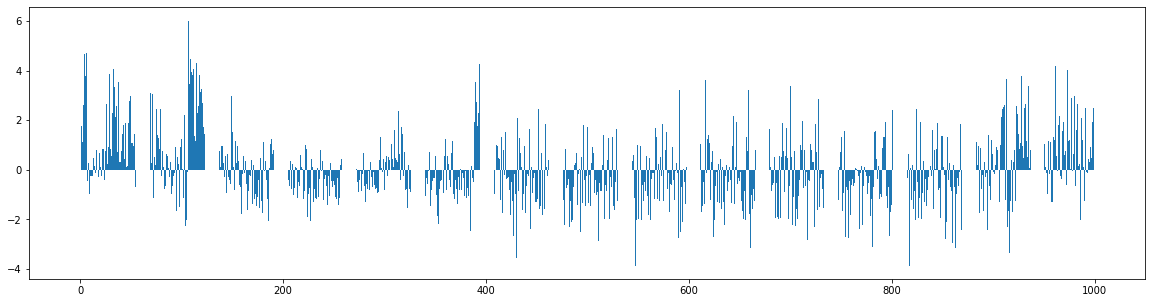

In [13]:
image_path = "104000.jpg"
embedding_ax_enc = db_ax_enc.embedding(image_path)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(len(embedding_ax_enc)), embedding_ax_enc)

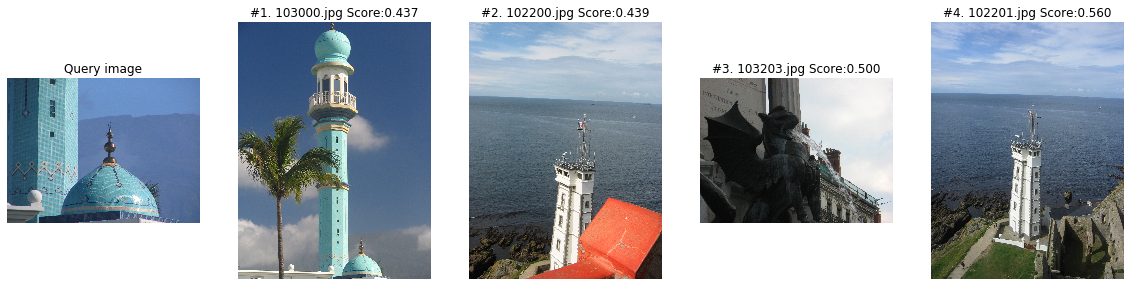

In [31]:
import random

query = random.choice(db_ax_enc.dataset.image_paths)
scores = db_ax_enc.retrieve(query)
db_ax_enc.show_results(query, scores, figsize=(20, 10))

**5.2 Using the features of a DCNN**

We can compare the results above in which we use AlexNet as an encoder with the DESCRIPTOR+VOCABULARY method, in which -- rather than using AlexNet as an encoder -- descriptors are taken from an intermediate layer of AlexNet; these are treated as feature vectors (multiple ones for each image) which are then encoded using a vocabulary tree.

In [16]:
# let's create the vocabulary tree using descriptors generated by a neural network
voc_nn = cbir.encoders.VocabularyTree(n_branches=4, depth=4, descriptor=cbir.descriptors.AlexNet())

In [17]:
# Now, let's extract the features using AlexNet
features = voc_nn.extract_features(dataset)

Extracting features...
Progress 100/100 - ETA: 0:00:00025691
437251 features extracted


In [18]:
# We can now construct the tree using the extracted features
voc_nn.fit(features)

In [19]:
# we create the model as usual
db_nn = cbir.Database(dataset, encoder=voc_nn)

In [20]:
# and now we index the database,
# which means that we calculate the embeddings for all the images and store them in db_nn._database
db_nn.index()


Generating index...


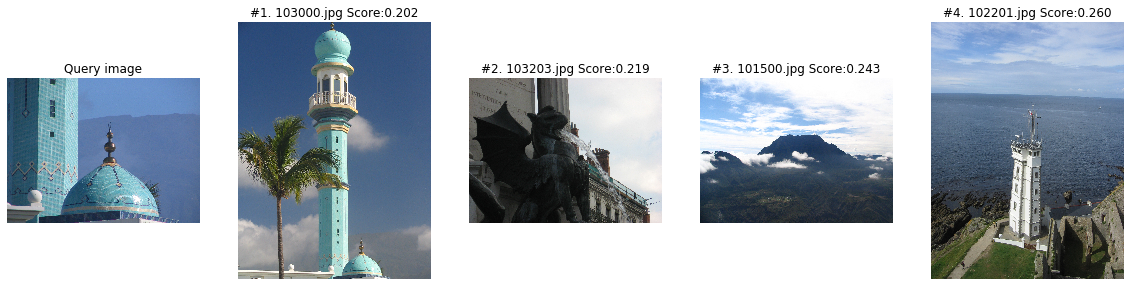

In [32]:
scores = db_nn.retrieve(query)
db_nn.show_results(query, scores, figsize=(20, 10))